# 1. Sentiment

## a. Analysis

In [1]:
import pandas as pd
from transformers import pipeline

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = pd.read_csv("../../Data Collection/Play Store/play_store_reviews_no_index.csv")
reviews = list(dataset["Reviews"])

[reviews[i] for i in range(5)]

["The app is awesome, I could learn a lot and choose what language as well as teachers who I want to study with, the interface is awesome, easy to understand and has a lot of fitures. I don't know if the others is having the troubles, but in my realme 7 device, the app has drain a lot of battery consumsion in the background, even if I don't open it at all. I hope and I know that Cakap Team would help solve problem and perfecting the app. Thanks",
 "This app works on me. But in my opinion, it still needs to be improved, especially when I change the screen to horizontal, the video cannot display the duration of the video being played. So if I want to loop or jump to my desired sequence, it's a little annoying. Because I can only press 10 seconds ahead before or after. Hopefully you can fix it, but this app is great because there is no buffering while watching videos 😀😊",
 "Just downloaded, update profile then reatarted, then stuck on boot the apps and stopped in C sign only. I've waited 

In [3]:
def analyze_sentiment(text_to_analyze):
    # Specify the model and revision explicitly
    model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"

    # Load the sentiment analysis pipeline with explicit model
    sentiment_analyzer = pipeline(
        "sentiment-analysis",
        model=model_name,
        tokenizer=model_name
    )

    # Perform sentiment analysis
    sentiment_result = sentiment_analyzer(text_to_analyze)

    return sentiment_result

In [4]:
sentiments = analyze_sentiment(reviews)

[sentiments[i] for i in range(5)]

[{'label': 'positive', 'score': 0.9887719750404358},
 {'label': 'negative', 'score': 0.7605188488960266},
 {'label': 'negative', 'score': 0.9924700260162354},
 {'label': 'positive', 'score': 0.9887719750404358},
 {'label': 'negative', 'score': 0.7605188488960266}]

In [5]:
def get_df(sentences, sentiments):
    sents = {
        'review': sentences,
        'label': [senti['label'] for senti in sentiments],
        'score': [senti['score'] for senti in sentiments]
    }

    df = pd.DataFrame(sents)
    return df

In [6]:
senti_df = get_df(reviews, sentiments)
senti_df.head()

,review,label,score
0,"The app is awesome, I could learn a lot and ch...",positive,0.988772
1,"This app works on me. But in my opinion, it st...",negative,0.760519
2,"Just downloaded, update profile then reatarted...",negative,0.992470
3,"The app is awesome, I could learn a lot and ch...",positive,0.988772
4,"This app works on me. But in my opinion, it st...",negative,0.760519


In [7]:
senti_df.to_csv("../../Data Analysis/Play Store/play_store_reviews_sentiment.csv", index=False)

## b. Visualization

In [24]:
import altair as alt
import matplotlib.pyplot as plt

### 1) sentiments distribution

In [25]:
def pie_chart(poss, negs):
    total = poss + negs
    poss_perc = str(poss/total*100)+"%"
    negs_perc = str(negs/total*100)+"%"

    source = pd.DataFrame({
        "Label": ["Positive", "Negative"],
        "Count": [poss, negs],
        "Percentage": [poss_perc, negs_perc]
    })

    pie = alt.Chart(source).mark_arc().encode(
        theta="Count",
        color=alt.Color(
            "Label",
            scale=alt.Scale(
                domain=["Positive", "Negative"],
                range=["#19c2fa", "#fc3f3f"]
            )),
        tooltip=["Label", "Count", "Percentage"]
    )

    return pie

In [26]:
def pie_chart(result, labels):
    plt.figure(figsize=(8, 8))
    plt.pie(result, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.show()

In [27]:
def show_bar_chart(labels, counts):
    _, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(labels, counts, color=['#2394f7', '#f72323', '#fac343'])

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_ylabel('Frequency')

    plt.show()

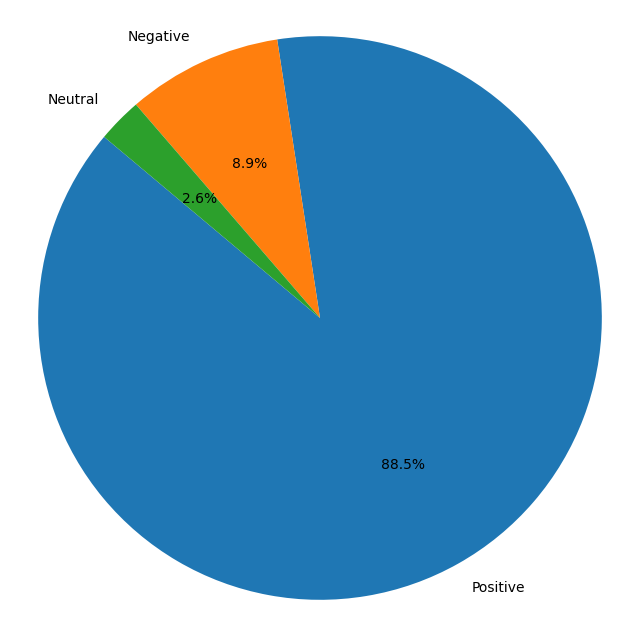

In [40]:
label_count = senti_df['label'].value_counts()
poss = label_count.get('positive')
negs = label_count.get('negative')
neuts = label_count.get("neutral")

# Given result list and labels
result = [poss, negs, neuts]
labels = ["Positive", "Negative", "Neutral"]

pie_chart(result, labels)

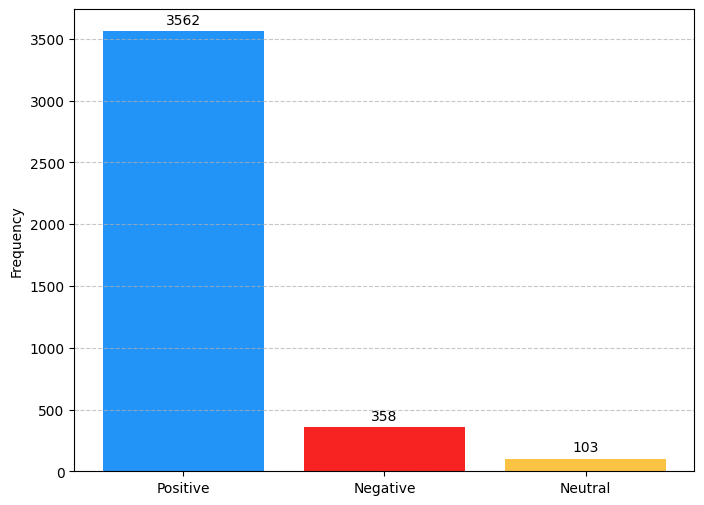

In [41]:
show_bar_chart(
    ["Positive", "Negative", "Neutral"],
    [poss, negs, neuts]
)

### 2) rating prediction

In [42]:
# Removing neutral sentiments because they aren't affecting
# the positivity or negativity
pos_neg_df = senti_df[senti_df["label"] != "NEUTRAL"]
pos_neg_df.head()

,review,label,score
0,"The app is awesome, I could learn a lot and ch...",positive,0.988772
1,"This app works on me. But in my opinion, it st...",negative,0.760519
2,"Just downloaded, update profile then reatarted...",negative,0.992470
3,"The app is awesome, I could learn a lot and ch...",positive,0.988772
4,"This app works on me. But in my opinion, it st...",negative,0.760519


In [43]:
positivity = senti_df.apply(lambda row: 1 - row['score'] if row['label'] == 'NEGATIVE' else row['score'], axis=1)
normalized_scores = [(score * 4) + 1 for score in (positivity)]

In [44]:
import numpy as np

def hist(normalized_scores):
    bin_width = 0.5
    num_bins = int((max(normalized_scores) - min(normalized_scores)) / bin_width)

    plt.hist(normalized_scores, bins=num_bins, edgecolor='black')
    plt.xlabel('Normalized Scores')
    plt.ylabel('Frequency')
    plt.title(f'Average Rating: {np.mean(normalized_scores):.2f}')
    plt.show()

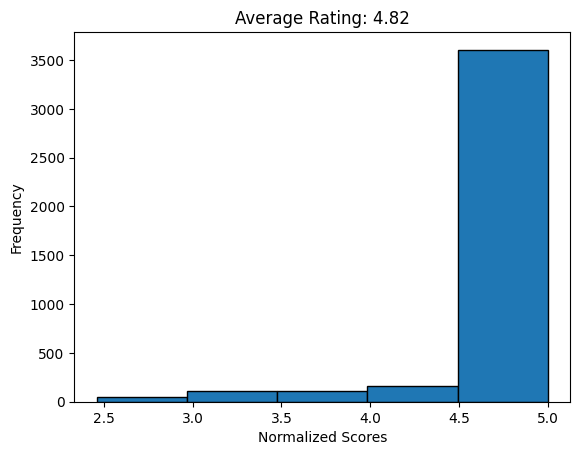

In [45]:
hist(normalized_scores)

# 2. Topic Modelling

In [60]:
import pyLDAvis
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from nlp_id.stopword import StopWord
from gensim.parsing.preprocessing import preprocess_string
import pyLDAvis.gensim_models as gensimvis

## a. Preprocessing

In [61]:
documents = reviews

# Remove Indonesian stop words
stopword = StopWord()
stop_removed = [stopword.remove_stopword(text) for text in reviews]

# Preprocess text
processed_docs = [preprocess_string(doc) for doc in stop_removed]

# Create dictionary
dictionary = corpora.Dictionary(processed_docs)

# Create bag-of-words corpus
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## b. Training and Visualization

In [79]:
# Train LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, passes=50)

In [82]:
# Visualize topics
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

## c. Coherence Score

In [81]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.69568244063984


# 3. Word Cloud

In [65]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## a. Preprocessing

In [73]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))

    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()
              and token not in stop_words]
    return tokens

In [74]:
text = " ".join(reviews)
tokens = preprocess_text(text)

## b. Visualization

In [75]:
def generate_wordcloud(words):
    # Generate WordCloud for adjectives
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white').generate(words)

    # Display the WordCloud using matplotlib
    _, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')

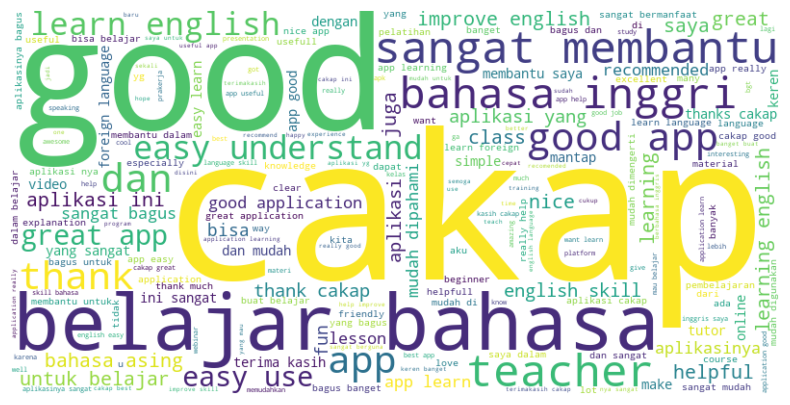

In [76]:
processed_text = " ".join(tokens)
generate_wordcloud(processed_text)